<a href="https://colab.research.google.com/github/knwin/ArcGIS_DeepLearning/blob/main/extracting_building_footprints_from_drone_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extracting Building Footprints From Drone Data
> * 🔬 Data Science
* 🥠 Deep Learning and pixel-based classification

## Table of Contents
* [Introduction](#Introduction)
* [Export Training Data](#Export-Training-Data)
 * [Rasterize Building Footprints](#Rasterize-Building-Footprints)
 * [Reclassify the Rasterized Building Footprints](#Reclassify-the-Rasterized-Building-Footprints)
 * [Convert to a Themetic Raster with Pixel Type 8bit unsigned](#Convert-to-a-Themetic-Raster-with-Pixel-Type-8bit-unsigned)
 * [Export training data](#Export-training-data)
* [Train the Model](#Train-the-Model)
 * [Required Imports](#Required-Imports)
 * [Prepare Data](#Prepare-Data)
 * [Visualise few samples from your Training data](#Visualise-few-samples-from-your-Training-data)
 * [Load an UnetClassifier model](#Load-an-UnetClassifier-model)
 * [Find an Optimal Learning Rate](#Find-an-Optimal-Learning-Rate)
 * [Fit the model](#Fit-the-model)
 * [Save the model](#Save-the-model)
 * [Load an Intermediate model to train it further](#Load-an-Intermediate-model-to-train-it-further)
 * [Preview Results](#Preview-Results)
* [Deploy Model and Extract Footprints](#Deploy-Model-and-Extract-Footprints)
 * [Generate a Classified Raster using Classify Pixels Using Deep Learning tool](#Generate-a-Classified-Raster-using-Classify-Pixels-Using-Deep-Learning-tool)
 * [Streamline Postprocessing Workflow Using Model Builder](#Streamline-Postprocessing-Workflow-Using-Model-Builder)
 * [Final Output](#Final-Output)
* [Limitations](#Limitations)


## Introduction

Building footprints is a required layer in lot of mapping exercises, for example in basemap preparation, humantitarian aid and disaster management, transportation and a lot of other applications it is a critical component.Traditionally GIS analysts delineate building footprints by digitizing aerial and high resolution satellite imagery.

This sample shows how ArcGIS API for Python can be used to train a deep learning model to extract building footprints from drone data. The models trained can be used with ArcGIS Pro or ArcGIS Enterprise and even support distributed processing for quick results.

> For this sample we will be using data which originates from USAA and covers the region affected by Woolsey fires. The Imagery used here is an orthomosaic of data acquired just after the fires using an optical sensor on drone with a spatial resolution of 30cm.


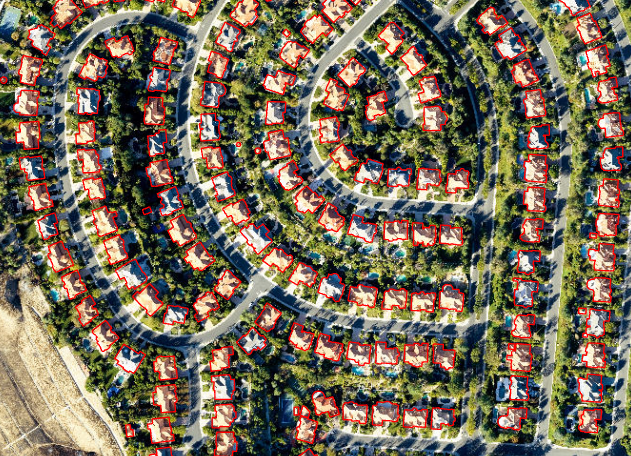

<center>A subset of Drone Imagery Used overlayed with Training Data (Building Footprint Layer).</center>

In this workflow we will basically have three steps.
* Export Training Data
* Train a Model
* Deploy Model and Extract Footprints

## Export Training Data

Training data can be exported by using the 'Export Training Data For Deep Learning' tool available in [ArcGIS Pro](#"https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm") as well as [ArcGIS Enterprise](#"https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm"). For this example we prepared training data in 'Classified Tiles' format using a 'chip_size' of 400px and 'cell_size' of 30cm in ArcGIS Pro. 



### Rasterize Building Footprints
Rasterize building footprints using <a href="https://pro.arcgis.com/en/pro-app/tool-reference/conversion/polygon-to-raster.htm">'Polgon to Raster'</a> tool.
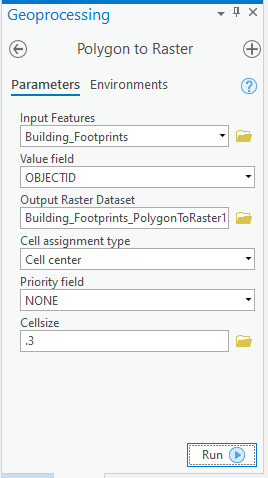
<center>Rasterize Building Footprints</center>


```python
arcpy.conversion.PolygonToRaster("Building_Footprints", "OBJECTID", r"C:\sample\sample.gdb\Building_Footprints_PolygonToRaster", "CELL_CENTER", "NONE", 0.3)
```

### Reclassify the Rasterized Building Footprints

Convert all NoData values to '0' and other values to '1' using [Reclassify Raster](https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/an-overview-of-the-raster-reclass-toolset.htm) tool.
 After selecting input raster click on 'classify' and set only one class. For the class with 'valid data range' Set 'New' value to '1' for 'NoData' set 'New' value to '0'.

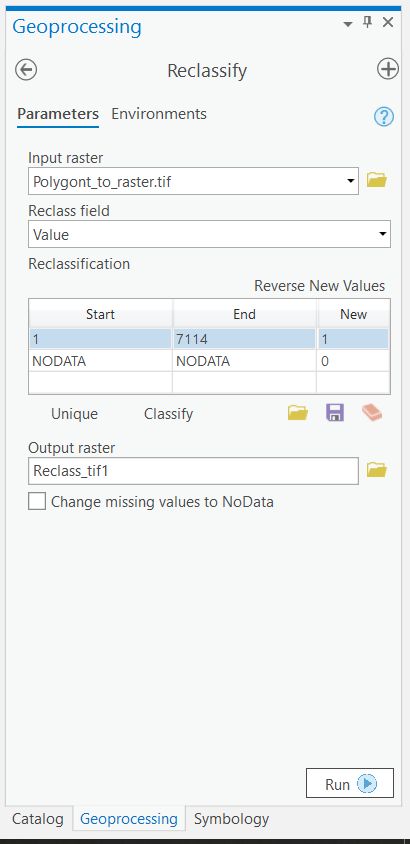
<center>Reclassify Raster</center>

```python
arcpy.ddd.Reclassify("Building_Footprints_PolygonToRaster", "Value", "1 1;NODATA 0", r"C:\sample\sample.gdb\Building_Footprints_PolygonToRaster_reclass", "DATA")
```

### Convert  to a Themetic Raster with Pixel Type '8bit unsigned'  
Export the reclassified raster from the previous step to a '8bit unsigned' raster.
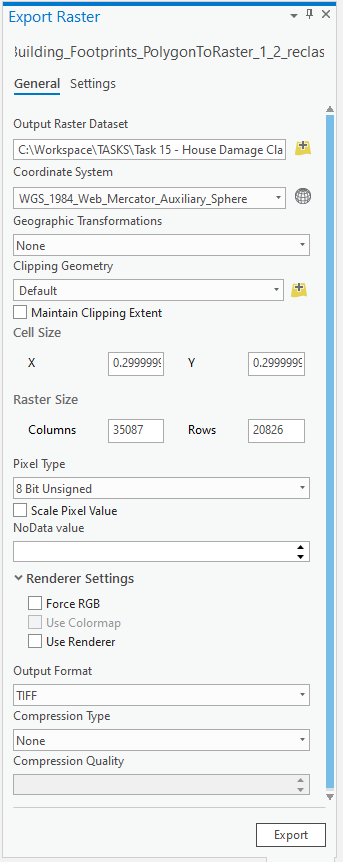
<center>Export Raster</center>


```python
arcpy.management.CopyRaster(r"C:\sample\sample.gdb\Building_Footprints_PolygonToRaster_reclass", r"C:\sample\sample.gdb\Building_Footprints_PolygonToRaster_reclass_8bitu", '', None, '', "NONE", "NONE", "8_BIT_UNSIGNED", "NONE", "NONE", "GRID", "NONE", "CURRENT_SLICE", "NO_TRANSPOSE")
```

Open 'Catalog Pane' > navigate to the raster you just exported > Right Click and select 'Properties'. In the 'Raster Properties' pane change the source type to 'Themetic'.
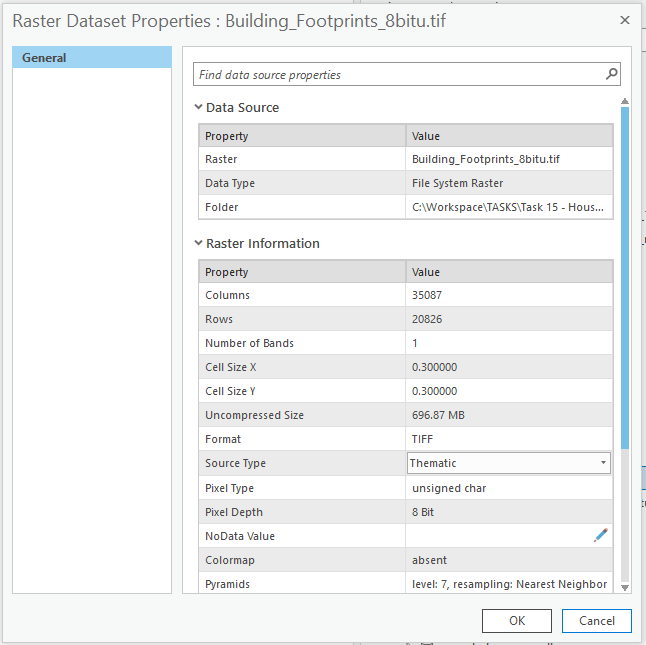
<center>Set the Source Type of Raster to Thematic.</center>


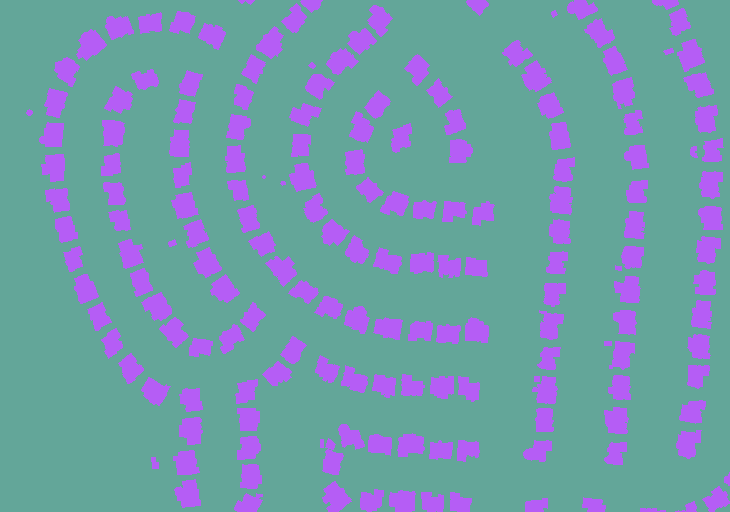
<center>A Subset of our Themetic Raster generated by the previous steps.</center>

### Export training data
Export training data using 'Export Training data for deep learning' tool, [detailed documentation here](#https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm)
- Set drone imagery as 'Input Raster'.
- Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
- Set classified raster as 'Input Feature Class Or Classified Raster'.
- In the option 'Input Mask Polygons' we can set a mask layer to limit the tool to export training data for only those areas which have buildings in it, we created one by generating a grid of 200m by 200m on building footprint layer's extent and dissolving only those polygons which contained buildings to a single multipolygon feature.
- 'Tile Size X' & 'Tile Size Y' can be set 
- Select 'Classified Tiles' as the 'Meta Data Format' because we are training an 'Unet Model'.
- In 'Environments' tab set an optimum 'Cell Size' which is small enough to allow model to learn the texture of building roofs by the details and big enough to allow multiple buildings to fall in one tile and model can also understand the surrounding context of the buildings. For this example we used 0.3 cell size which meant 30cm on a project coordinate system. 
<div>

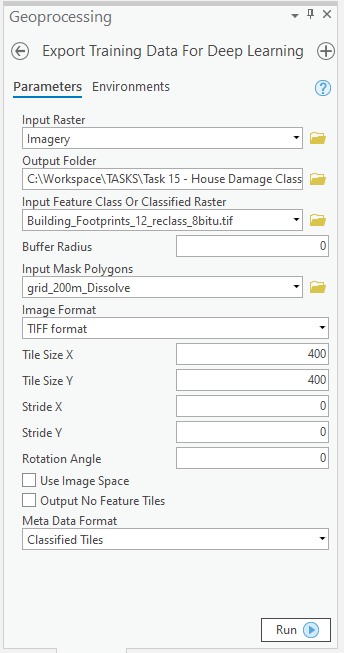
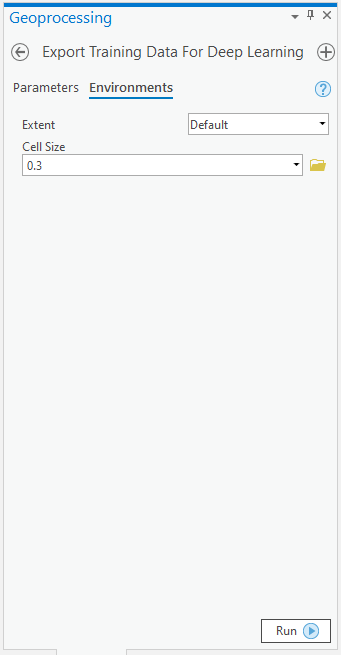
</div>

```python
arcpy.ia.ExportTrainingDataForDeepLearning("Imagery", r"C:\sample\Data\Training Data 400px 30cm", "Building_Footprints_8bitu.tif", "TIFF", 400, 400, 0, 0, "ONLY_TILES_WITH_FEATURES", "Classified_Tiles", 0, None, 0, "grid_200m_Dissolve", 0, "MAP_SPACE", "NO_BLACKEN", "Fixed_Size")
```

This will create all the necessary files needed for the next step in the 'Output Folder', and we will now call it our training data.

**INSTALL CONDA ON GOOGLE COLAB**

code ref: github dataprofessor/code

In [ ]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Install arcgis api, deep learning packages

[ref: setup guide](https://developers.arcgis.com/python/guide/install-and-set-up/)

In [ ]:
! conda install -c esri -c fastai -c pytorch arcgis=1.8.2 scikit-image=0.15.0 pillow=6.2.2 libtiff=4.0.10 fastai=1.0.60 pytorch=1.4.0 torchvision=0.5.0 --no-pin

Solving environment: \ failed with initial frozen solve. Retrying with flexible solve.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - arcgis=1.8.2
    - fastai=1.0.60
    - libtiff=4.0.10
    - pillow=6.2.2
    - pytorch=1.4.0
    - scikit-image=0.15.0
    - torchvision=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    arcgis-1.8.2               |        py37_1275         3.3 MB  es

## Train the Model

This step would be done using jupyter notebook and documentation is available <a href="https://developers.arcgis.com/python/guide/install-and-set-up/"> here to install and setup environment</a>. 

### Required Imports


In [ ]:
import os
from pathlib import Path

import arcgis
from arcgis.gis import GIS
from arcgis.learn import prepare_data

### Prepare Data

We would specify the path to our training data and a few hyper parameters.

`path`: path of folder containing training data.<br/>
`chip_size`: Same as per specified while exporting training data<br/>
`batch_size`: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.

In [ ]:
gis = GIS() #GIS('home')

In [ ]:
training_data = gis.content.get('2f9058a37129460fac8a661c5d462a5f')
training_data

<Item title:"extracting_building_footprints_from_drone_data" type:Image Collection owner:api_data_owner>

In [ ]:
filepath = training_data.download(file_name=training_data.name)

In [ ]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [ ]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

In [ ]:
filepath

'/tmp/extracting_building_footprints_from_drone_data.zip'

In [ ]:
# Prepare Data
data = prepare_data(path=data_path,
                    chip_size=400, 
                    batch_size=8)


FileNotFoundError: ignored

### Visualise a few samples from your Training data
The code below shows a few samples of our data with the same symbology as in ArcGIS Pro.

`rows`: No of rows we want to see the results for.<br>
`alpha`: controls the opacity of labels(Classified imagery) over the drone imagery

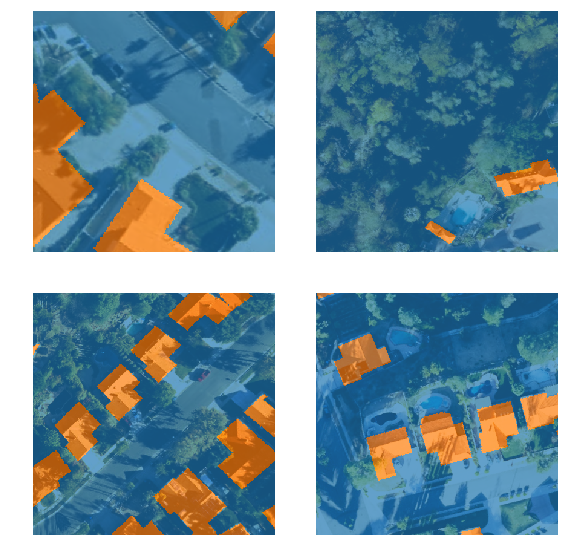

In [ ]:
data.show_batch(rows=2, alpha=0.7)

### Load an `UnetClassifier` model

The Code below will create an `UnetClassifier` model, it is based on a state of art deep learning model architecture 'U-net'. This type of model is used where 'pixel wise segmention' or in GIS terminology 'imagery classification' is needed, by default this model will be loaded on a pretrained resnet backbone.  

In [ ]:
# Create Unet Model
model = arcgis.learn.models.UnetClassifier(data)

### Find an Optimal Learning Rate

Optimization in deep learning is all about tuning 'hyperparameters'. In this step we will find an 'optimum learning rate' for our model on the training data. Learning rate is a very important parameter, while training our model it will see the training data several times and adjust itself (the weights of the network). Too high learning rate will lead to the convergence of our model to an suboptimal solution and too low learning can slow down the convergence of our model. We can use the `lr_find()` method to find an optimum learning rate at which can train a robust model fast enough. 

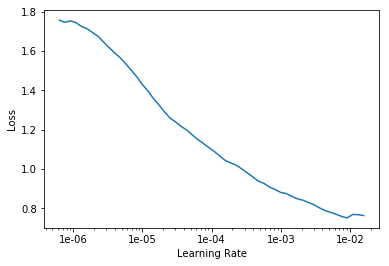

In [ ]:
# Find Learning Rate
model.lr_find()

The above method passes small batches of data to the model at a range of learning rates while records the losses for the respective learning rate after trainig. The result is this graph where loss has been plotted at y-axis with the respective learning rate at x-axis. Looking at the above graph we can see that the loss continously decreases after 1e-06 or .000001 and continous falling untill  bumping back at 1e-02, we can now pick any value near to the center of this steepest decline. Now we will pick 1e-03 or .001 so that can be set the highest learning rate and lowest learning rate a tenth of it in the next step.

### Fit the model

We would fit the model for 30 `epochs`. One epoch mean the model will see the complete training set once and so on.

In [ ]:
# Training
model.fit(30, lr=slice(0.0001, 0.001))

The full training data was split into training set and validation set at the [Prepare Data step](#Prepare-Data), by default the validation set is .2 or 20% of the full training data and the remaining 80% goes in the training set. Here we can see loss on both training and validatiaon set, it helps us to be aware about how well our model generalizes on data which it has never seen and prevent overfitting of the model. Also as we can see our model here is able to classify pixels to building or non building with an accuracy of 96%.

### Save the model

We would now save the model which we just trained as a 'Deep Learning Package' or '.dlpk' format. Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. `UnetClassifier` models can be deployed by the tool 'Classify Pixels Using Deep Learning' available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>. For this sample we will using this model in ArcGIS Pro to extract building footprints.

We will use the `save()` method to save the model and by default it will be saved to a folder 'models' inside our training data folder itself.

In [ ]:
# Save model to file
model.save('30e')

### Load an Intermediate model to train it further

If we need to further train an already saved model we can load it again using the code below and go back to [Train the model step](#Train-the-Model) and further train it.

In [ ]:
# Load Model from previous saved files 
# model.load('30e')

### Preview Results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

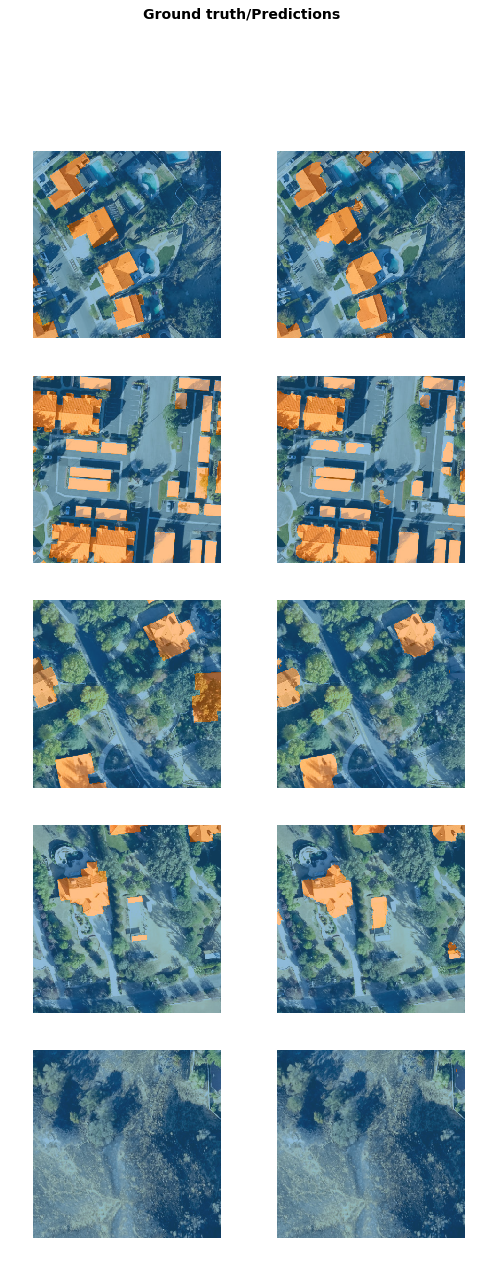

In [ ]:
# Preview Results
model.show_results()

## Deploy Model and Extract Footprints

The deep learning package saved in previous step can be used to extract classfied raster using 'Classify Pixels Using Deep Learning' tool.
Further the classfied raster is regularised and finally converted to a vector Polygon layer. The regularisation step uses advanced ArcGIS geoprocessing tools to remove unwanted artifacts in the output. 

### Generate a 'Classified Raster' using 'Classify Pixels Using Deep Learning' tool

In this step we will generate a classfied raster using 'Classify Pixels Using Deep Learning' tool available in both <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> and <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>.

- Input Raster: The raster layer from which we want to extract building footprints from.
- Model Definition: It will be located inside the saved model in 'models' folder in '.emd' format.
- padding: The 'Input Raster' is tiled and the deep learning model classifies each individual tile separately before producing the final 'Output Classified Raster'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accuratly. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- Cell Size: Should be close to at which we trained the model, we specified that at the [Export training data step]("#Export-training-data") .
- Processor Type: This allows to control wether the system's 'GPU' or 'CPU' would be used in to classify pixels, by 'default GPU' will be used if available.
- Parallel Processing Factor: This allows us to scale this tool, this tool can be scaled on both 'CPU' and 'GPU'. It specifies that the opration would be spread across how many 'cpu cores' in case of cpu based operation or 'no of GPU's' incase of GPU based operation.
<div>
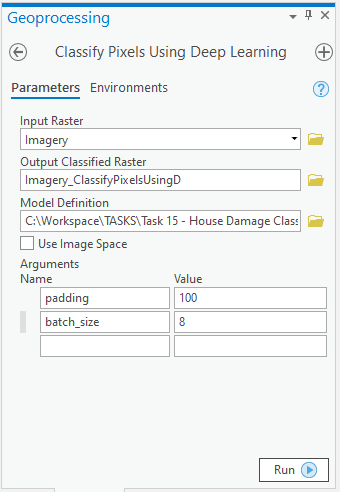
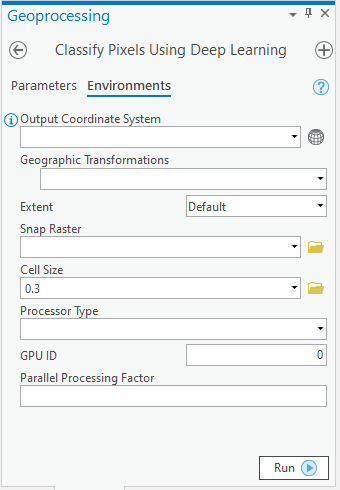
</div>


```python
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("Imagery", r"C:\sample\Data\Training Data 400px 30cm\models\30e\30e.emd", "padding 100;batch_size 8"); 
out_classified_raster.save(r"C:\sample\sample.gdb\Imagery_ClassifyPixelsUsingD")
```

Output of this tool will be in form of a 'classified raster' containing both background and building footprints.
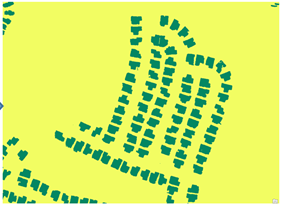
<center>A subset of preditions by our Model</center>

###  Streamline Postprocessing Workflow Using Model Builder

As postprocessing workflow below involves quite a few tools and the parameters set in these tools need to be experimented with to get optimum results. We would use model builder to streamline this for us and enable us iteratively change the parameters in this workflow. 

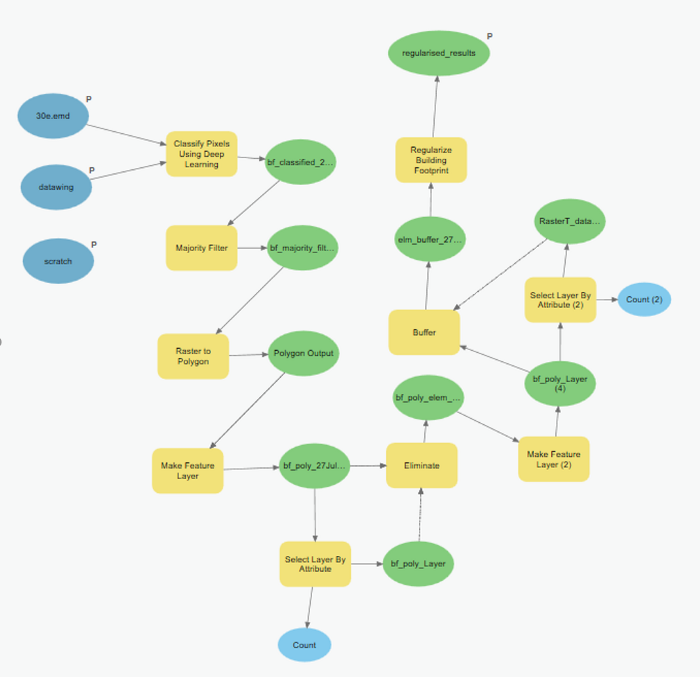
<center>Postprocessing workflow in Model Builder.</center>




Tools used and important parameters:
- Majority Filter: Reduces noise in the classified raster, we would use 'four' neighbouring cells majority to smoothen the raster.
- Raster to Polygon: Vectorizes raster to polygon based on cell values, we will keep the 'Simplify Polygons' and 'Create Multipart Features' options unchecked.
- Eliminate: Removes selected records by merging them into nieghbouring features, we selected features below 10 sqm Area before using this tool to remove small unwanted noise that  Vectorizes raster to polygon based on cell values, we will keep the 'Simplify Polygons' and 'Create Multipart Features' options unchecked.
- Buffer: To slightly increase coverage of buildings we would buffer them by '5cm'. Before buffering them we would select only building features this will remove background features from output of this tool.
- Regularize Building Footprints: This tool will produce the final finished results by shaping them to how actual buildings look. 'Method' for regularisation would be 'Right Angles and Diagnol' and the parameters 'tolerance', 'Densification' and 'Precision' are '1.5', '1', '0.25' and '2' respectively. 

Attached below is the toolbox:

<Item title:"Building_footprint_post_processing" type:Geoprocessing Sample owner:api_data_owner>
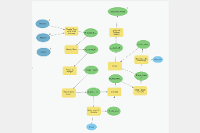

In [ ]:
from arcgis.gis import GIS
gis = GIS(username='api_data_owner')
gis.content.get('4bbb65755af24ff895581b39dc1d73e9')

### Final Output

The final output will be in form of a feature class.

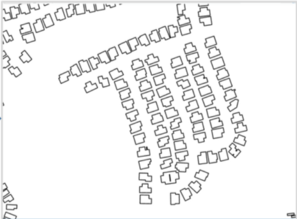
<center>A subset of Extracted Building Footprints after Post Processing.</center>

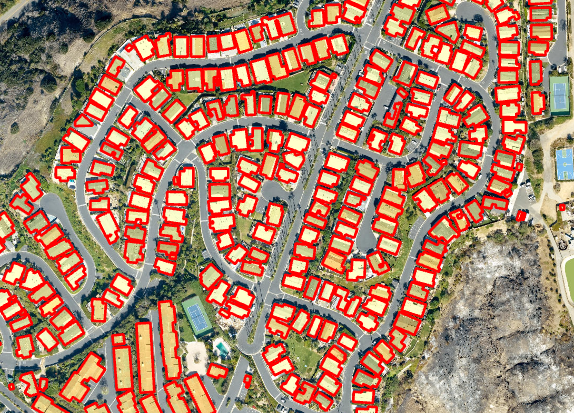

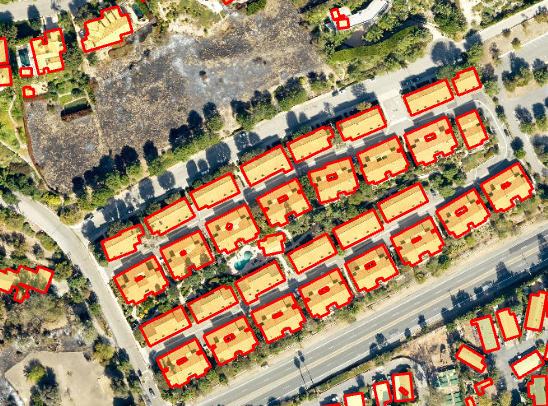

<center>A few subsets of results overlayed on the drone imagery</center>

## Limitations

This type of model works well when buildings are seperated from each other by some distance. In some conditions where buildings are touching each other instance segmentation models should be tried as it would always give better results.